## <center>Курсовой проект<center>

### Постановка задачи

**Задача**

Требуется, на основании имеющихся данных о клиентах банка, построить модель, используя обучающий датасет, для прогнозирования невыполнения долговых обязательств по текущему кредиту. Выполнить прогноз для примеров из тестового датасета.

**Наименование файлов с данными**

course_project_train.csv - обучающий датасет<br>
course_project_test.csv - тестовый датасет

**Целевая переменная**

Credit Default - факт невыполнения кредитных обязательств

**Метрика качества**

F1-score (sklearn.metrics.f1_score)

**Требования к решению**

*Целевая метрика*
* F1 > 0.5
* Метрика оценивается по качеству прогноза для главного класса (1 - просрочка по кредиту)

*Решение должно содержать*
1. Тетрадка Jupyter Notebook с кодом Вашего решения, названная по образцу {ФИО}\_solution.ipynb, пример SShirkin\_solution.ipynb
2. Файл CSV с прогнозами целевой переменной для тестового датасета, названный по образцу {ФИО}\_predictions.csv, пример SShirkin\_predictions.csv

*Рекомендации для файла с кодом (ipynb)*
1. Файл должен содержать заголовки и комментарии (markdown)
2. Повторяющиеся операции лучше оформлять в виде функций
3. Не делать вывод большого количества строк таблиц (5-10 достаточно)
4. По возможности добавлять графики, описывающие данные (около 3-5)
5. Добавлять только лучшую модель, то есть не включать в код все варианты решения проекта
6. Скрипт проекта должен отрабатывать от начала и до конца (от загрузки данных до выгрузки предсказаний)
7. Весь проект должен быть в одном скрипте (файл ipynb).
8. Допускается применение библиотек Python и моделей машинного обучения,
которые были в данном курсе.

### Решение

**Подключим библиотеки**

In [6]:
!pip install catboost

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [7]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import random
from scipy.stats import mode
import warnings
warnings.filterwarnings('ignore')
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, ShuffleSplit, cross_val_score, learning_curve
from sklearn.model_selection import KFold, GridSearchCV, RandomizedSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
import xgboost as xgb, lightgbm as lgbm, catboost as catb
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report, f1_score
%matplotlib inline

**Пропишем пути к файлам**

In [8]:
DS_TEST_PATH = 'course_project_test.csv'
DS_TRAIN_PATH = 'course_project_train.csv'

**Загрузим датасет**

In [9]:
X = pd.read_csv(DS_TRAIN_PATH)
y = pd.DataFrame({'Credit Default': X['Credit Default']})

X_test = pd.read_csv(DS_TEST_PATH)
X.head()

,Home Ownership,Annual Income,Years in current job,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Months since last delinquent,Bankruptcies,Purpose,Term,Current Loan Amount,Current Credit Balance,Monthly Debt,Credit Score,Credit Default
0,Own Home,482087.0,NaN,0.0,11.0,26.3,685960.0,1.0,NaN,1.0,debt consolidation,Short Term,99999999.0,47386.0,7914.0,749.0,0
1,Own Home,1025487.0,10+ years,0.0,15.0,15.3,1181730.0,0.0,NaN,0.0,debt consolidation,Long Term,264968.0,394972.0,18373.0,737.0,1
2,Home Mortgage,751412.0,8 years,0.0,11.0,35.0,1182434.0,0.0,NaN,0.0,debt consolidation,Short Term,99999999.0,308389.0,13651.0,742.0,0
3,Own Home,805068.0,6 years,0.0,8.0,22.5,147400.0,1.0,NaN,1.0,debt consolidation,Short Term,121396.0,95855.0,11338.0,694.0,0
4,Rent,776264.0,8 years,0.0,13.0,13.6,385836.0,1.0,NaN,0.0,debt consolidation,Short Term,125840.0,93309.0,7180.0,719.0,0


**Описание датасета**

* **Home Ownership** - домовладение
* **Annual Income** - годовой доход
* **Years in current job** - количество лет на текущем месте работы
* **Tax Liens** - налоговые обременения
* **Number of Open Accounts** - количество открытых счетов
* **Years of Credit History** - количество лет кредитной истории
* **Maximum Open Credit** - наибольший открытый кредит
* **Number of Credit Problems** - количество проблем с кредитом
* **Months since last delinquent** - количество месяцев с последней просрочки платежа
* **Bankruptcies** - банкротства
* **Purpose** - цель кредита
* **Term** - срок кредита
* **Current Loan Amount** - текущая сумма кредита
* **Current Credit Balance** - текущий кредитный баланс
* **Monthly Debt** - ежемесячный долг
* **Credit Default** - факт невыполнения кредитных обязательств (0 - погашен вовремя, 1 - просрочка)

**Посмотрим матрицу корреляций, для определения признаков, имеющих зависимость между собой**

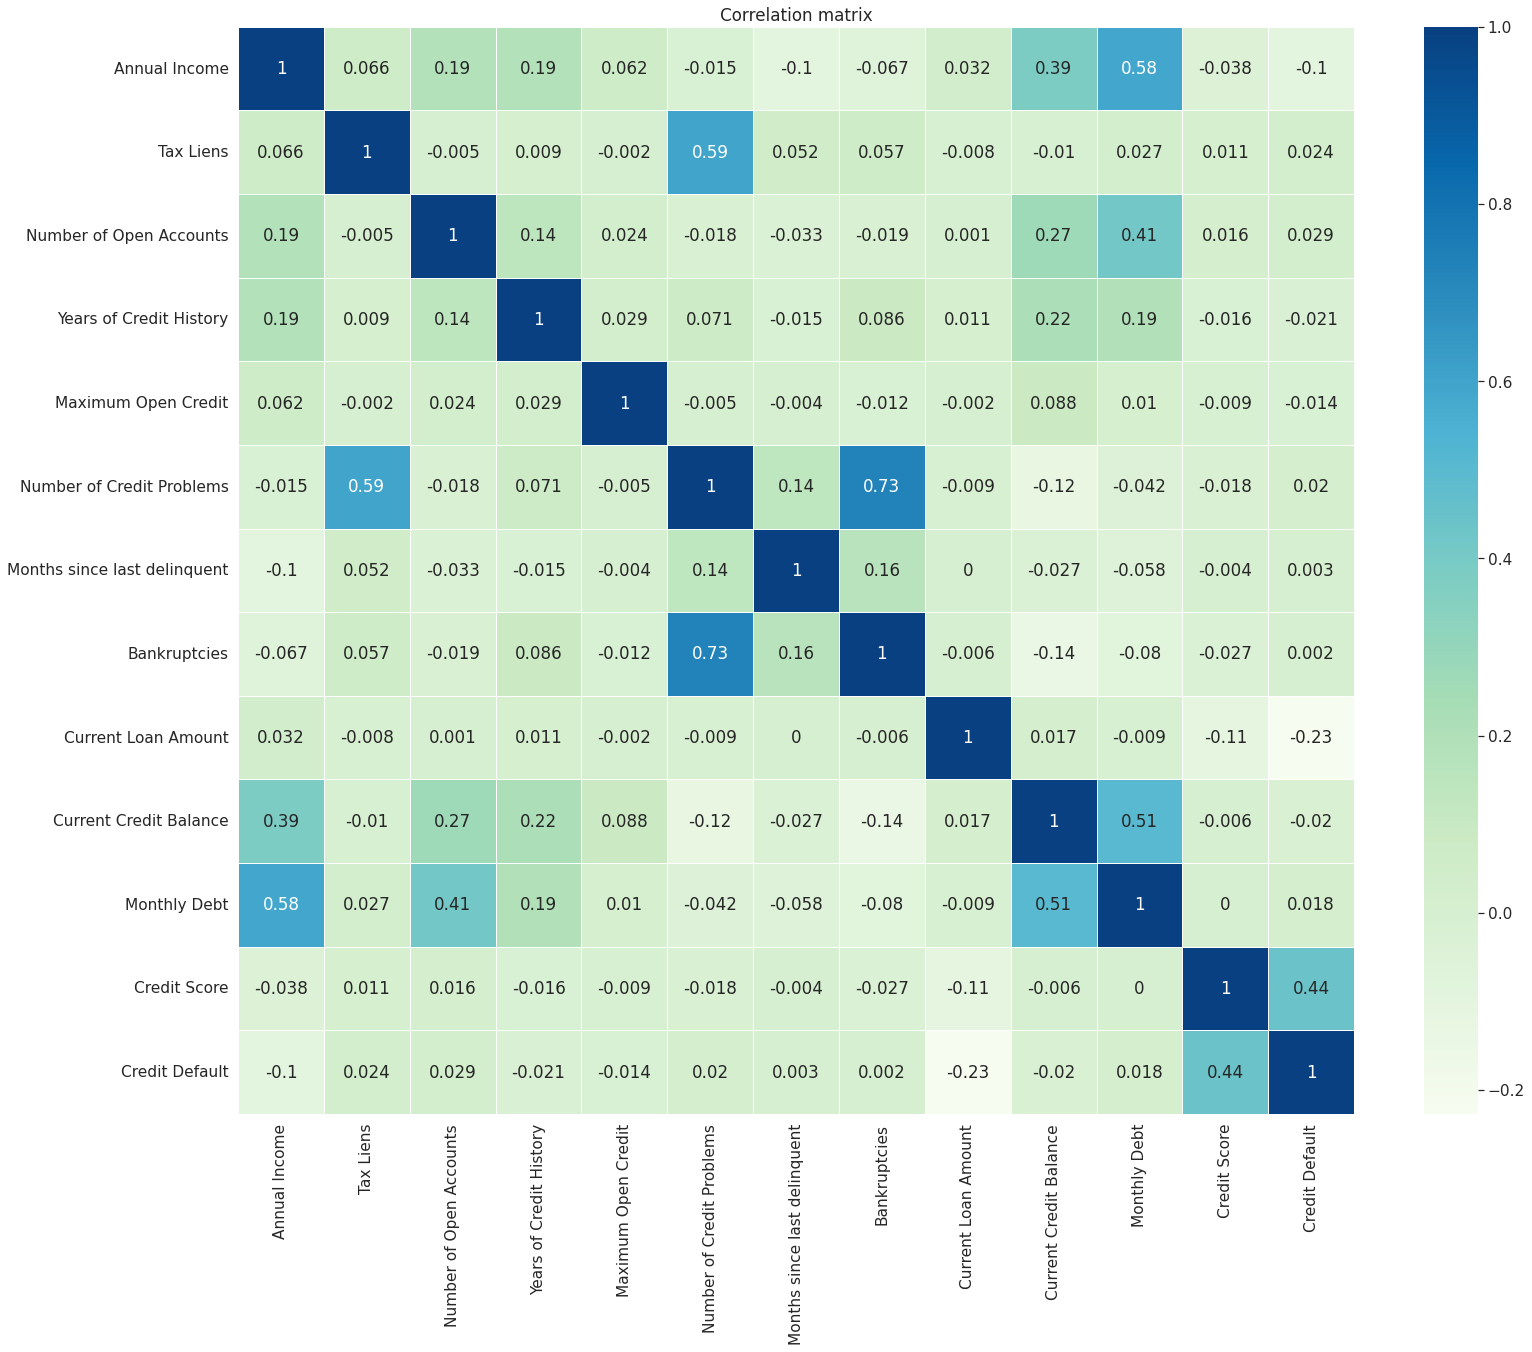

In [10]:
plt.figure(figsize = (25,20))

sns.set(font_scale=1.4)
sns.heatmap(X.corr().round(3), annot=True, linewidths=.5, cmap='GnBu')

plt.title('Correlation matrix')
plt.show()

Наиболее заметна зависимость между 'Bankruptcies' и 'Number of Credit Problems'. Пока мы оставим данные признаки, но в последствии можем удалить какой-нибудь при выборе и настройки модели.

**Посмотрим на распределение признаков**

array([[<AxesSubplot:title={'center':'Annual Income'}>,
        <AxesSubplot:title={'center':'Tax Liens'}>,
        <AxesSubplot:title={'center':'Number of Open Accounts'}>,
        <AxesSubplot:title={'center':'Years of Credit History'}>],
       [<AxesSubplot:title={'center':'Maximum Open Credit'}>,
        <AxesSubplot:title={'center':'Number of Credit Problems'}>,
        <AxesSubplot:title={'center':'Months since last delinquent'}>,
        <AxesSubplot:title={'center':'Bankruptcies'}>],
       [<AxesSubplot:title={'center':'Current Loan Amount'}>,
        <AxesSubplot:title={'center':'Current Credit Balance'}>,
        <AxesSubplot:title={'center':'Monthly Debt'}>,
        <AxesSubplot:title={'center':'Credit Score'}>],
       [<AxesSubplot:title={'center':'Credit Default'}>, <AxesSubplot:>,
        <AxesSubplot:>, <AxesSubplot:>]], dtype=object)

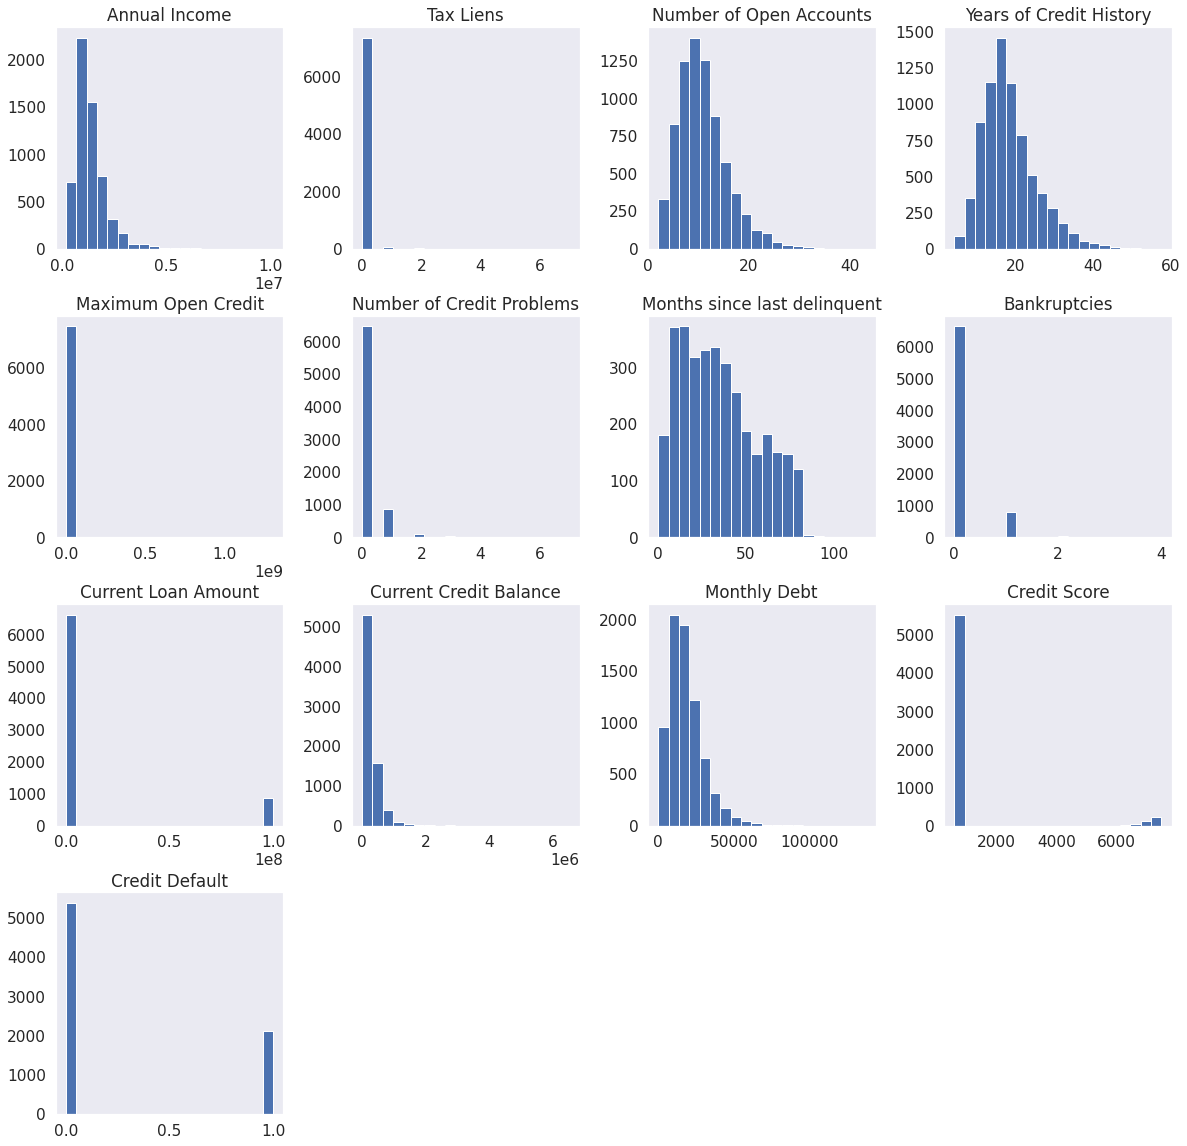

In [11]:
X.hist(figsize=(20, 20), bins=20, grid=False)

Сразу видим, что у нас дисбаланс классов целевой переменной 'Credit Default', тренировочную выборку мы сбалансируем.

Признак 'Current Loan Amount' имеет выбросы в качестве значений 99999999 - заменим их на среднее (далее в программе).

Теперь проверим датасет на наличие пропусков:

In [12]:
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7500 entries, 0 to 7499
Data columns (total 17 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   Home Ownership                7500 non-null   object 
 1   Annual Income                 5943 non-null   float64
 2   Years in current job          7129 non-null   object 
 3   Tax Liens                     7500 non-null   float64
 4   Number of Open Accounts       7500 non-null   float64
 5   Years of Credit History       7500 non-null   float64
 6   Maximum Open Credit           7500 non-null   float64
 7   Number of Credit Problems     7500 non-null   float64
 8   Months since last delinquent  3419 non-null   float64
 9   Bankruptcies                  7486 non-null   float64
 10  Purpose                       7500 non-null   object 
 11  Term                          7500 non-null   object 
 12  Current Loan Amount           7500 non-null   float64
 13  Cur

In [13]:
X.isna().sum()

Home Ownership                     0
Annual Income                   1557
Years in current job             371
Tax Liens                          0
Number of Open Accounts            0
Years of Credit History            0
Maximum Open Credit                0
Number of Credit Problems          0
Months since last delinquent    4081
Bankruptcies                      14
Purpose                            0
Term                               0
Current Loan Amount                0
Current Credit Balance             0
Monthly Debt                       0
Credit Score                    1557
Credit Default                     0
dtype: int64

Как видим, у нас 5 признаков с пропусками. Рассмотрим каждый более подробно, что бы определить каким образом сможем заполнить пропуски.

**'Annual Income'** - годовой доход. Вещественный признак - заменим на среднее значение.

In [14]:
X['Annual Income'].value_counts()

1338113.0    4
969475.0     4
1161660.0    4
1043651.0    4
1058376.0    4
            ..
1272316.0    1
712082.0     1
695476.0     1
678889.0     1
402192.0     1
Name: Annual Income, Length: 5478, dtype: int64

**'Years in current job'** - количество лет на текущем месте работы. Дискретный признак - заменим на моду.

In [15]:
X['Years in current job'].value_counts()

10+ years    2332
2 years       705
3 years       620
< 1 year      563
5 years       516
1 year        504
4 years       469
6 years       426
7 years       396
8 years       339
9 years       259
Name: Years in current job, dtype: int64

**'Months since last delinquent'** - количество месяцев с последней просрочки платежа

Данный параметр мы могли бы привязать к 'Credit Default', но это целевое значение, а значит для предсказания мы не можем её использовать.

In [16]:
X['Months since last delinquent'].value_counts()

14.0     76
29.0     71
33.0     68
8.0      68
12.0     65
         ..
86.0      1
118.0     1
84.0      1
91.0      1
92.0      1
Name: Months since last delinquent, Length: 89, dtype: int64

In [17]:
X.loc[X['Number of Credit Problems'] == 0, 'Months since last delinquent'].mode()[0]

14.0

In [18]:
X.loc[X['Number of Credit Problems'] > 0, 'Months since last delinquent'].mode()[0]

8.0

In [19]:
X.loc[X['Number of Credit Problems'] == 0, 'Months since last delinquent'].value_counts()

14.0     68
19.0     62
13.0     62
33.0     61
29.0     60
         ..
83.0      3
86.0      1
118.0     1
84.0      1
92.0      1
Name: Months since last delinquent, Length: 88, dtype: int64

In [20]:
X.loc[X['Months since last delinquent'].isnull(), 'Number of Credit Problems'].value_counts()

0.0    3557
1.0     468
2.0      38
3.0      15
4.0       3
Name: Number of Credit Problems, dtype: int64

Привяжем признак 'Months since last delinquent' к 'Number of Credit Problems', если 'Number of Credit Problems' = 0, то  'Months since last delinquent' = моде, но только для тех значений, где 'Number of Credit Problems' = 0, иначе - 'Months since last delinquent' - моде во всем остальном диапазоне.

**'Bankruptcies'**. Дискретный признак - заменим на моду.

In [21]:
X['Bankruptcies'].value_counts()

0.0    6660
1.0     786
2.0      31
3.0       7
4.0       2
Name: Bankruptcies, dtype: int64

**'Credit Score'**. Дискретный признак - заменим на моду.

In [22]:
X['Credit Score'].value_counts()

740.0     169
747.0     168
748.0     157
745.0     152
742.0     151
         ... 
616.0       1
6600.0      1
629.0       1
6820.0      1
6060.0      1
Name: Credit Score, Length: 268, dtype: int64

**Создание класса для преобразования данных**

In [23]:
class DataPrepare:


    def __init__(self):
        self.CurrentLoanAmount_median = None
        self.AnnualIncome_median = None
        self.Yearsincurrentjob_mode = None
        self.Bankruptcies_mode = None
        self.CreditScore_mode = None
        
    
    def fit(self, df):
        # вычисление медианы и моды 
        self.CurrentLoanAmount_median = df['Current Loan Amount'].median()
        self.AnnualIncome_median = df['Annual Income'].median()
        self.Yearsincurrentjob_mode = df['Years in current job'].mode()[0]
        self.Bankruptcies_mode = df['Bankruptcies'].mode()[0]
        self.CreditScore_mode = df['Credit Score'].mode()[0]
        
        
    def transform(self, df):
        
        #Разабъем Purpose,так как значение не числовые
        df['P_1'] = df['Purpose'].isin(['medical bills']) * 1
        df['P_2'] = df['Purpose'].isin(['buy a car']) * 1
        df['P_3'] = df['Purpose'].isin(['home improvements']) * 1
        df['P_4'] = df['Purpose'].isin(['buy house']) * 1
        df['P_5'] = df['Purpose'].isin(['major purchase']) * 1
        df['P_6'] = df['Purpose'].isin(['other']) * 1
        df['P_7'] = df['Purpose'].isin(['wedding']) * 1
        df['P_8'] = df['Purpose'].isin(['small business']) * 1
        df['P_9'] = df['Purpose'].isin(['renewable energy']) * 1
        df['P_10'] = df['Purpose'].isin(['educational expenses']) * 1
        df['P_11'] = df['Purpose'].isin(['business loan']) * 1
        df['P_12'] = df['Purpose'].isin(['take a trip']) * 1
        df['P_13'] = df['Purpose'].isin(['vacation']) * 1
        df['P_14'] = df['Purpose'].isin(['moving']) * 1
        df['P_15'] = df['Purpose'].isin(['debt consolidation']) * 1
        #Преобразуем в числовое значение параметр 'Years in current job'
        df.loc[df['Years in current job'].isnull(), 'Years in current job'] = self.Yearsincurrentjob_mode 
        df.loc[df['Years in current job'] == '9 years', 'Years in current job'] = 9
        df.loc[df['Years in current job'] == '7 years', 'Years in current job'] = 7
        df.loc[df['Years in current job'] == '6 years', 'Years in current job'] = 6
        df.loc[df['Years in current job'] == '4 years', 'Years in current job'] = 4
        df.loc[df['Years in current job'] == '8 years', 'Years in current job'] = 8
        df.loc[df['Years in current job'] == '1 year', 'Years in current job'] = 1
        df.loc[df['Years in current job'] == '5 years', 'Years in current job'] = 5
        df.loc[df['Years in current job'] == '10+ years', 'Years in current job'] = 10
        df.loc[df['Years in current job'] == '3 years', 'Years in current job'] = 3
        df.loc[df['Years in current job'] == '2 years', 'Years in current job'] = 2
        df.loc[df['Years in current job'] == '< 1 year', 'Years in current job'] = 0.5
        #заменим выброс на медиану
        df.loc[df['Current Loan Amount'] == 99999999, 'Current Loan Amount'] = self.CurrentLoanAmount_median    
        #замена пропусков
        df.loc[df['Annual Income'].isnull(), 'Annual Income'] = self.AnnualIncome_median    
        df.loc[((df['Months since last delinquent'].isnull()) & (df['Number of Credit Problems'] == 0)), 'Months since last delinquent'] = df.loc[df['Number of Credit Problems'] == 0, 'Months since last delinquent'].mode()[0]
        df.loc[((df['Months since last delinquent'].isnull()) & (df['Number of Credit Problems'] > 0)), 'Months since last delinquent'] = df.loc[df['Number of Credit Problems'] > 0, 'Months since last delinquent'].mode()[0]    
        df.loc[df['Bankruptcies'].isnull(), 'Bankruptcies'] = self.Bankruptcies_mode    
        df.loc[df['Credit Score'].isnull(), 'Credit Score'] = self.CreditScore_mode
        #для Term сделаем бинарные значения
        df['term_binary'] = df['Term'].map({'Short Term':'1', 'Long Term':'0'}).astype(int)
        #Кодируем признак 'Home Ownership'
        df = pd.concat([df, pd.get_dummies(df['Home Ownership'], prefix='H_O')], axis=1)
        #удаляем уже не нужные признаки
        df.drop(columns=['Home Ownership', 'Term', 'Purpose'], inplace=True)
        #присваиваем столбцу новый тип данных
        df['Years in current job'] = df['Years in current job'].astype(float)
        
        
    
        return df
    

In [24]:
def std(df):#функция для стандартизации датасета
    df_norm = df.copy()
    df_norm[NUM_FEATURE_NAMES] = scaler.fit_transform(df_norm[NUM_FEATURE_NAMES])
    
    return df_norm

In [25]:
def balance_df_by_target(df, target_name): #функуция для балансировки тренировочного датасета

    target_counts = df[target_name].value_counts()

    major_class_name = target_counts.argmax()
    minor_class_name = target_counts.argmin()

    disbalance_coeff = int(target_counts[major_class_name] / target_counts[minor_class_name]) - 1

    for i in range(disbalance_coeff):
        sample = df[df[target_name] == minor_class_name].sample(target_counts[minor_class_name])
        df = df.append(sample, ignore_index=True)

    return df.sample(frac=1) 

**Разбиение основного датасета на тренировочный и валидационный и обработка данных**

In [26]:

X.drop(columns='Credit Default', inplace=True)
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.25, random_state=42)


In [27]:
a = DataPrepare()
a.fit(X)

**Удаление выбросов и заполнение пропусков тренировочного датасета**

In [28]:
train = a.transform(X_train)
X_train = train.copy()

**Балансировка тренировочного датасета**

In [29]:
df_for_balancing = pd.concat([X_train, y_train], axis=1)
df_balanced = balance_df_by_target(df_for_balancing, 'Credit Default')
df_balanced['Credit Default'].value_counts()

0    4074
1    3102
Name: Credit Default, dtype: int64

In [30]:
X_train = df_balanced.drop(columns='Credit Default')
y_train = df_balanced['Credit Default']


**Удаление выбросов и заполнение пропусков валидационного датасета(по которому будем проверять работу модели)**

In [31]:
valid = a.transform(X_valid)
X_valid = valid.copy()


**Удаление выбросов и заполнение пропусков тестового датасета(у которого нет известной целевой переменной, результаты предсказания для данного дата сета попробуем проверить в kaggle)**

In [32]:
test = a.transform(X_test)
X_test = test.copy()


**Нормализация данных**

In [33]:
scaler = StandardScaler()


In [34]:
CAT_FEATURE_NAMES = ['H_O_Rent', 'H_O_Own Home', 'H_O_Home Mortgage', 'H_O_Have Mortgage', 'term_binary', 'P_1', 'P_2', 'P_3', 'P_4', 'P_5', 'P_6', 'P_7', 'P_8', 'P_9', 'P_10', 'P_11', 'P_12', 'P_13', 'P_14', 'P_15']
NUM_FEATURE_NAMES = ['Annual Income', 'Number of Open Accounts', 'Years of Credit History', 'Number of Credit Problems', 'Bankruptcies', 'Tax Liens', 'Years in current job', 'Maximum Open Credit', 'Months since last delinquent', 'Current Loan Amount', 'Current Credit Balance', 'Monthly Debt', 'Credit Score']
TTL = CAT_FEATURE_NAMES + NUM_FEATURE_NAMES
len(TTL)

33

In [35]:
train_std = std(X_train)
test_std = std(X_test)
valid_std = std(X_valid)


In [36]:
X_train = train_std.copy()
X_valid = valid_std.copy()
X_test = test_std.copy()


### Построение и оценка базовых моделей<a class="anchor" id="baseline_modeling"></a> 

Были проанализированы следующие модели:
- дерево решений; результат 0,4399
- k-ближайших соседей; результат 0,4528
- XGBoost; результат 0,4364
- LightGBM; результат 0,4364
- логистическая регрессия; результат 0,5198<br>
и последняя, которая стала основной - CatBoost; результат 0,5396 (после подбора параметров)

**CatBoost**

In [58]:
final_model = catb.CatBoostClassifier(class_weights=[1, 3.5], n_estimators=1600, max_depth=7,
                                      silent=True, random_state=21)
final_model.fit(X_train, y_train)

y_train_pred = final_model.predict(X_train)
y_valid_pred = final_model.predict(X_valid)
f1_score(y_valid, y_valid_pred)

0.5375854214123007

**Визуализация важности признаков**

In [44]:
def show_feature_importances(feature_names, feature_importances, get_top=None):
    feature_importances = pd.DataFrame({'feature': feature_names, 'importance': feature_importances})
    feature_importances = feature_importances.sort_values('importance', ascending=False)
       
    plt.figure(figsize = (20, len(feature_importances) * 0.355))
    
    sns.barplot(feature_importances['importance'], feature_importances['feature'])
    
    plt.xlabel('Importance')
    plt.title('Importance of features')
    plt.show()
    
    if get_top is not None:
        return feature_importances['feature'][:get_top].tolist()

**Удалим из датасета наименее влиятельные признаки и пересчитаем метрику**

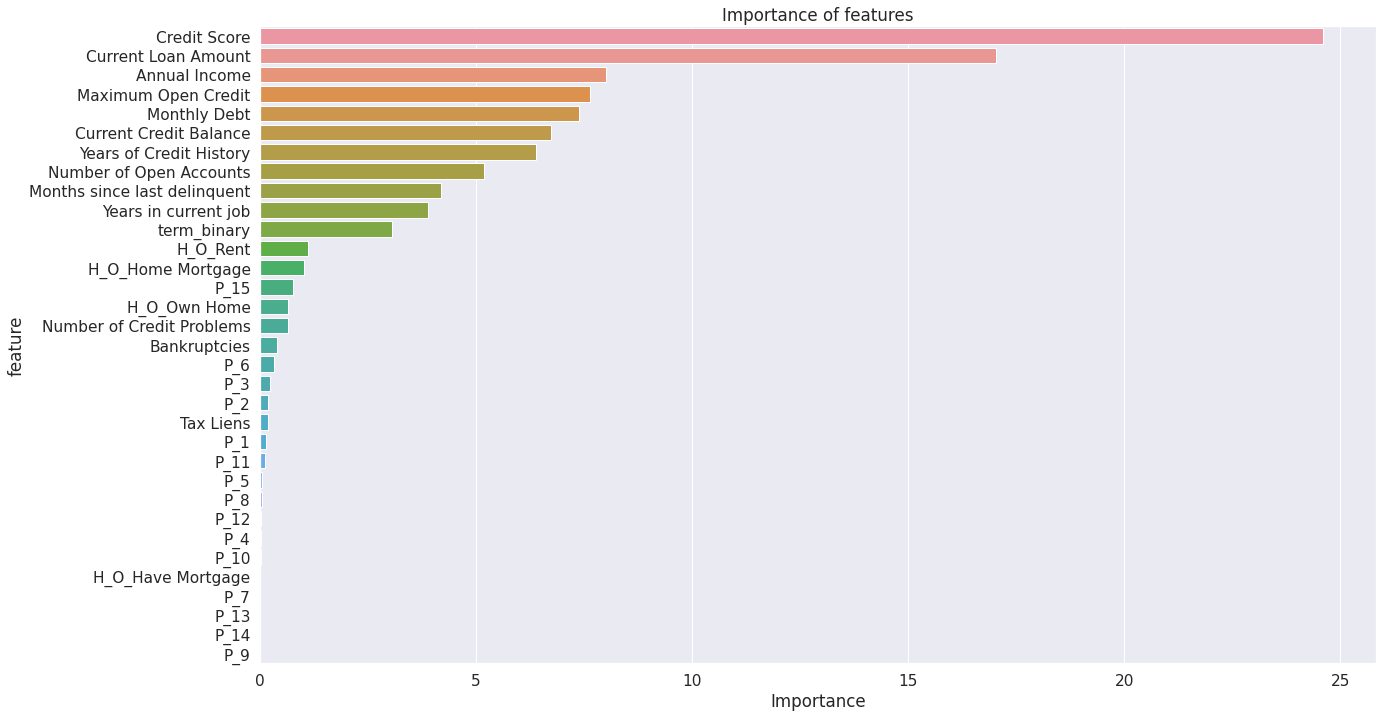

In [45]:
important_features_top = show_feature_importances(X_train.columns, final_model.feature_importances_, get_top=15)

In [40]:
X_new_train = X_train.drop(columns=['P_4', 'P_5', 'P_7', 'P_8', 'P_9', 'P_10', 'P_12', 'P_13', 'P_14', 'P_15', 'H_O_Have Mortgage'])
X_new_valid = X_valid.drop(columns=['P_4', 'P_5', 'P_7', 'P_8', 'P_9', 'P_10', 'P_12', 'P_13', 'P_14', 'P_15', 'H_O_Have Mortgage'])
final_model = catb.CatBoostClassifier(class_weights=[1, 3.5], n_estimators=1700, max_depth=7,
                                      silent=True, random_state=21)
final_model.fit(X_new_train, y_train)

y_train_pred = final_model.predict(X_new_train)
y_valid_pred = final_model.predict(X_new_valid)
f1_score(y_valid, y_valid_pred)

0.5298113207547169

Как видим, удаление признаков не принесло нам результата

**Предсказание для данных, которые не имеют ответов и запись резульатов в файл**

In [46]:
y_test_pred = final_model.predict(X_test)

In [47]:
y_test_pred.shape

(2500,)

In [48]:
result=pd.DataFrame({'Id':np.arange(2500), 'Credit Default': y_test_pred})

In [49]:
result.to_csv('AVNeronov_predictions.csv', index = False)
result.head()

,Id,Credit Default
0,0,1
1,1,1
2,2,1
3,3,1
4,4,0
